# Imports

In [ ]:
import pandas as pd
import numpy as np

---

# Carga de datos

In [ ]:
auctions = pd.read_pickle("../../../../data/tp2/auctions_tp2_formateado.pkl")

---

# Armado de ventanas

In [ ]:
for ventana_nro in range(1,6):
    auctions["ventana_{}".format(ventana_nro)] = (((17+ventana_nro) <= auctions["date"].dt.day) & ((auctions["date"].dt.day) <= (19+ventana_nro)))

---

# Creación de features

## Creación de sets de entrenamiento

In [ ]:
Xs = {}
for ventana_nro in range(1,6):
    Xs[ventana_nro] = auctions.loc[auctions["ventana_{}".format(ventana_nro)]]["device_id"].drop_duplicates().to_frame().set_index("device_id")

---

## Función generadora de features

In [ ]:
def generar_feature_en_ventanas(dataframe, generador_feature, destinos):
    for ventana_nro in range(1, 6):
        feature = generador_feature(dataframe.loc[dataframe["ventana_{}".format(ventana_nro)]], ventana_nro)
        destinos[ventana_nro] = destinos[ventana_nro].merge(feature, left_index=True, right_index=True)

---

## Cantidad de apariciones en subastas dentro de la ventana

In [ ]:
def cantidad_apariciones_en_subastas(dataframe, nro_ventana):
    return dataframe.groupby("device_id").agg({"date" : "count"}).rename(columns={"date": "cantidad_apariciones"})

In [ ]:
generar_feature_en_ventanas(auctions, cantidad_apariciones_en_subastas, Xs)

---

## Cantidad de apariciones discriminando períodos

In [ ]:
# Creo columnas para luego separar
auctions['hora'] = auctions['date'].dt.hour
auctions['dia'] = auctions['date'].dt.day
auctions['dia_de_la_semana'] = auctions['date'].dt.dayofweek

In [ ]:
def cantidad_apariciones_por_hora(dataframe, nro_ventana):
    apariciones_por_hora = dataframe.groupby(["device_id", "hora"]).agg(({"date" : "count"}))
    apariciones_por_hora = apariciones_por_hora.unstack().fillna(0).astype(np.int64)
    apariciones_por_hora.columns = ["apariciones_en_hora_{}".format(hora) for hora in range(0,24)]
    return apariciones_por_hora

In [ ]:
generar_feature_en_ventanas(auctions, cantidad_apariciones_por_hora, Xs)

In [ ]:
def cantidad_apariciones_por_dia(dataframe, nro_ventana):
    dias = dataframe["dia"].drop_duplicates
    apariciones_por_dia = dataframe.groupby(["device_id", "dia"]).agg(({"date" : "count"}))
    apariciones_por_dia = apariciones_por_dia.unstack().fillna(0).astype(np.int64)
    apariciones_por_dia.columns = ["apariciones_en_dia_{}".format(dia) for dia in range(1,4)]
    return apariciones_por_dia

In [ ]:
generar_feature_en_ventanas(auctions, cantidad_apariciones_por_dia, Xs)

---

## Sistema operativo (Android / iOS)

In [ ]:
def cantidad_so_registrados(dataframe, nro_ventana):
    return dataframe.groupby("device_id").agg({"ref_type_id" : "nunique"}).rename(columns={"ref_type_id": "cantidad_so_registrados"})

In [ ]:
generar_feature_en_ventanas(auctions, cantidad_so_registrados, Xs)

In [ ]:
# Tarda MUCHO
def sistema_operativo_principal(dataframe, nro_ventana):
    return dataframe.groupby("device_id").agg({"ref_type_id" : (lambda x: x.value_counts().index[0])}).rename(columns={"ref_type_id": "so_mas_usado"})

In [ ]:
generar_feature_en_ventanas(auctions, sistema_operativo_principal, Xs)

---

In [ ]:
def media_so(dataframe, nro_ventana):
    return dataframe.groupby("device_id").agg({"ref_type_id" : "mean"}).rename(columns={"ref_type_id": "so_media"})

In [ ]:
generar_feature_en_ventanas(auctions, media_so, Xs)

---

## Tiempo medio entre apariciones

In [ ]:
def tiempo_medio_entre_apariciones(dataframe, nro_ventana):
    gb = dataframe.groupby("device_id")
    ps = {}
    for t, g in gb:
        ps[t] = g["date"].sub(g["date"].shift()).mean()
    return pd.Series(ps).dt.total_seconds().fillna(0).to_frame().rename(columns={0: "tiempo_medio_entre_apariciones"})

In [ ]:
generar_feature_en_ventanas(auctions, tiempo_medio_entre_apariciones, Xs)

---

## Tiempo máximo entre apariciones

In [ ]:
def tiempo_maximo_entre_apariciones(dataframe, nro_ventana):
    gb = dataframe.groupby("device_id")
    ps = {}
    for t, g in gb:
        ps[t] = g["date"].sub(g["date"].shift()).max()
    return pd.Series(ps).dt.total_seconds().fillna(0).to_frame().rename(columns={0: "tiempo_maximo_entre_apariciones"})

In [ ]:
generar_feature_en_ventanas(auctions, tiempo_maximo_entre_apariciones, Xs)

---

## Desvío entre apariciones

In [21]:
# Tarda MUCHO
def desvio_entre_apariciones(dataframe, nro_ventana):
    gb = dataframe.groupby("device_id")
    ps = {}
    for t, g in gb:
        ps[t] = g["date"].sub(g["date"].shift()).std()
    return pd.Series(ps).dt.total_seconds().fillna(0).to_frame().rename(columns={0: "desvio_entre_apariciones"})

In [22]:
generar_feature_en_ventanas(auctions, desvio_entre_apariciones, Xs)

---

## Cantidad de apariciones por fuente

In [23]:
def cantidad_apariciones_segun_source(dataframe, nro_ventana):
    feature = dataframe.groupby(["device_id", "source_id"])["date"].agg("count").to_frame().unstack()
    feature.columns = ["apariciones_en_source_{}".format(x) for x in range(10)]
    feature = feature.fillna(0).astype(np.int64)
    return feature

In [24]:
generar_feature_en_ventanas(auctions, cantidad_apariciones_segun_source, Xs)

---

## Tiempo desde la última aparición hasta el fin de la ventana

In [25]:
def tiempo_desde_ult_aparicion_hasta_fin_ventana(dataframe, nro_ventana):
    return (np.datetime64("2019-04-2{}".format(nro_ventana)) - dataframe.groupby("device_id").agg({"date" : "max"})["date"]).dt.total_seconds().to_frame().rename(columns={"date": "tiempo_ultima_aparicion_hasta_fin_ventana"})

In [26]:
generar_feature_en_ventanas(auctions, tiempo_desde_ult_aparicion_hasta_fin_ventana, Xs)

---

## Tiempo desde t0 hasta horas más frecuentes

#### Funciones para evitar codigo repetido

In [6]:
def obtener_horas_aparicion_maxima(dataframe):
    """Devuelve un dataframe con la pinta {'device_id','hora','date'} donde cada dispositivo
    contiene todas las horas donde su aparición en subastas sea igual a la maxima """
    
    feature = dataframe.groupby(["device_id","hora"]).agg({"date":"count"})
    idx = feature.groupby(["device_id"])["date"].transform(max) == feature["date"]
    feature = feature[idx]
    feature.reset_index(inplace = True)
    return feature

In [7]:
def obtener_tiempo_hasta_hora_minima(feature):
    """Recibe un dataframe feature con horas de aparicion máxima y devuelve el
    tiempo hasta la hora minima para cada dispositivo"""
    segundos_en_hora = 60*60

    feature = feature.reset_index().groupby("device_id").agg({"hora":"min"})
    feature["hora"] = feature["hora"] * segundos_en_hora
    return feature
    

---

## Tiempo desde t0 hasta hora más frecuente de aparicion

#### Frente a empate entre horas me quedaré con la minima (la mas cercana a t0)

In [8]:
auctions["hora"] = auctions["date"].dt.hour


In [9]:
def tiempo_hasta_hora_minima_frecuente(dataframe,nro_ventana):
    segundos_en_hora = 60*60
    
    feature = obtener_horas_aparicion_maxima(dataframe)
    
    #Obtengo hora más cerca de t0 = 00 hs
    feature = obtener_tiempo_hasta_hora_minima(feature)
    feature.rename(columns = {"hora":"tiempo_hora_frec_aparicion_subasta"},inplace = True)
    
    return feature


In [ ]:
generar_feature_en_ventanas(auctions, tiempo_hasta_hora_minima_frecuente, Xs)

---

## Tiempo desde t0 hasta la segunda hora más frecuente de aparición

In [15]:
def tiempo_hasta_segunda_hora_minima_frecuente(dataframe,nro_ventana):
    
  
    feature = dataframe.groupby(["device_id","hora"]).agg({"date":"count"})
    feature.reset_index(inplace = True)
    
    
    apariciones_maximas = obtener_horas_aparicion_maxima(dataframe)
    apariciones_maximas.reset_index(inplace = True)

    
    
    #Obtengo los indices de las horas minimas de aparicion maxima para cada dispositivo
    horas_minimas = apariciones_maximas.groupby("device_id")["hora"].transform(min) == apariciones_maximas["hora"]

    apariciones_maximas = apariciones_maximas[horas_minimas]

    
    #Me quedo con los datos que no esten entre las horas minimas de aparicion maxima
    horas_no_minimas = ~( (feature.isin(apariciones_maximas)))
    #Todas las columnas deben ser True
    horas_no_minimas = horas_no_minimas.all(1)
    
        
    #Me quedo con los datos para completar aquellos dispositivos que solo contienen datos de una sola hora
    datos_restantes = feature[ ~(horas_no_minimas)]

    
    #Me quedo con los datos que excluyena las horas minimas 
    feature = feature[horas_no_minimas]
    


    #obtengo las apariciones maximas dentro de los valores restantes 
    feature = obtener_horas_aparicion_maxima(feature)
    
    
    #obtengo las horas minimas dentro de los valores restantes( segundas horas minimas)
    feature = obtener_tiempo_hasta_hora_minima(feature)

        
    #Me quedo con los datos que contienen solo una hora 
    apariciones_unicas = ~( (datos_restantes["device_id"].isin(feature.index)))
    
    datos_restantes = datos_restantes[apariciones_unicas]
  

    datos_restantes = obtener_tiempo_hasta_hora_minima(datos_restantes)
     
    
    feature = feature.append(datos_restantes)
    
    feature.rename(columns = {"hora":"tiempo_segunda_hora_frec_aparicion"},inplace = True)
    
    
    return feature


In [13]:
generar_feature_en_ventanas(auctions, tiempo_hasta_segunda_hora_minima_frecuente, Xs)

---

# En desarrollo

In [21]:
gb = auctions.groupby("device_id")
ps = {}
for t, g in gb:
    ps[t] = g["date"].sub(g["date"].shift()).mean()
medio = pd.Series(ps).dt.total_seconds().to_frame().rename(columns={0: "tiempo_medio_entre_apariciones"})

In [23]:
auctions.loc[auctions["device_id"] == 40621409780134]

,date,device_id,ref_type_id,source_id,ventana_1,ventana_2,ventana_3,ventana_4,ventana_5,hora,dia,dia_de_la_semana
36601349,2019-04-23 15:00:57.222979,40621409780134,1,0,False,False,False,True,True,15,23,1


In [24]:
medio.to_csv("tiempo_medio_por_device")

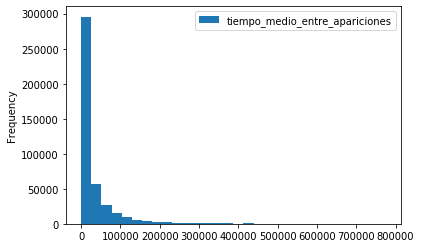

In [26]:
medio.plot(kind="hist", bins=30)

---

# Guardado de los sets de entrenamiento

In [16]:
for ventana_nro in range(1, 6):
    Xs[ventana_nro].to_pickle("../../features/auctions_train_ventana_{}.pkl".format(ventana_nro))
    Xs[ventana_nro].to_csv("../../features/auctions_train_ventana_{}.csv".format(ventana_nro))

---